In [3]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

import warnings
warnings.filterwarnings('ignore')

Урезанный dataset

In [4]:
df = pd.read_csv('datasets/nyt-ingredients-head.csv')
df.head(5)

,index,input,name,qty,range_end,unit,comment
0,0,1 1/4 cups cooked and pureed fresh butternut s...,butternut squash,1.25,0.0,cup,"cooked and pureed fresh, or 1 10-ounce package..."
1,1,1 cup peeled and cooked fresh chestnuts (about...,chestnuts,1.00,0.0,cup,"peeled and cooked fresh (about 20), or 1 cup c..."
2,2,"1 medium-size onion, peeled and chopped",onion,1.00,0.0,NaN,"medium-size, peeled and chopped"
3,3,"2 stalks celery, chopped coarse",celery,2.00,0.0,stalk,chopped coarse
4,4,1 1/2 tablespoons vegetable oil,vegetable oil,1.50,0.0,tablespoon,NaN


In [5]:
datafile = 'datasets/BIO_recipe_dataset.txt'
lines    = open(datafile, encoding='utf-8').read().strip().split('\n')

In [6]:
%load_ext autoreload
%autoreload 2

from utils.recipe_utils import  form_vocabulary_and_tagset, prepare_data, show_markup, Converter, predict_tags, tag_statistics, plot_confusion_matrix

In [7]:
# словарь и тэги
vocabulary,labels = form_vocabulary_and_tagset(lines)

# рецепты с тегами
recipes_w_tags = prepare_data(lines)
print(recipes_w_tags[0])

len(recipes_w_tags)

(['1$1/4', 'cups', 'cooked', 'and', 'pureed', 'fresh', 'butternut', 'squash', ',', 'or', '1', '10-ounce', 'package', 'frozen', 'squash', ',', 'defrosted'], ['B-QTY', 'B-UNIT', 'B-COMMENT', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'B-NAME', 'I-NAME', 'OTHER', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'B-NAME', 'OTHER', 'I-COMMENT'])


49847

In [8]:
# ner для первого рецепта
test_recipe, test_tags = recipes_w_tags[0]
show_markup(test_recipe, test_tags)

In [9]:
converter = Converter(vocabulary,labels)

# проверка работы энкодера и декодера
test_recipe, test_tags = recipes_w_tags[0]


encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()


decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

show_markup(decoded_recipe, decoded_tags)

tensor([  57, 2245, 2133, 1520, 4060, 2650, 1846, 4624,   25, 3729,   42,  125,
        3771, 2668, 4624,   25, 2303])
tensor([3, 5, 0, 6, 6, 6, 2, 7, 9, 6, 6, 6, 6, 6, 2, 9, 6])



In [10]:
# разделение на тестовую и тренировочную выборки
# возможно нужно будет попробовать другой способ
training_data = recipes_w_tags[     :40000]
test_data     = recipes_w_tags[40000:]

In [11]:
EMBEDDING_DIM = 32
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_with_idx)
TAGSET_SIZE   = len(converter.tag_with_idx)

In [12]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).tolist()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

In [13]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
loss_function = nn.NLLLoss() 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

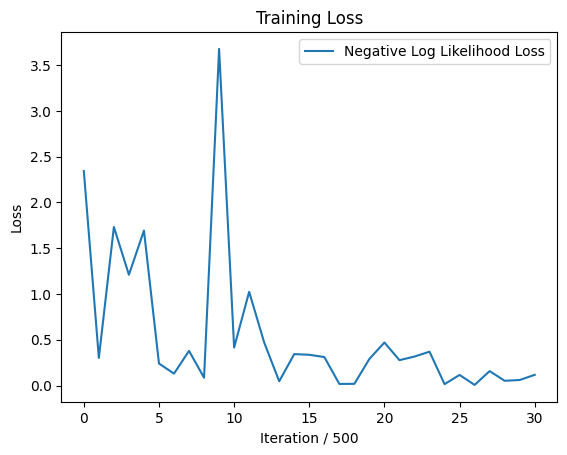

In [14]:
# Список для хранения значений потерь
loss_history = []

# Цикл обучения
for epoch in range(1): 
    for i, (recipe, tags) in enumerate(training_data):
        model.zero_grad()
        
        encoded_recipe = converter.words_to_index(recipe)  # слово -> его номер в словаре 
        encoded_tags   = converter.tags_to_index(tags)     # тэг   -> его номер в списке тэгов
        
        tag_scores     = model(encoded_recipe)
        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()
        
        # Сохраняем значение потери каждые 500 итераций
        if i % 500 == 0:
            loss_value = loss.item()  # Получаем скалярное значение из тензора
            loss_history.append(loss_value)
            
            
        # Прерываем цикл после 15000 итераций
        if i == 15000:
            break


plt.plot(loss_history, label='Negative Log Likelihood Loss')
plt.xlabel('Iteration / 500')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [15]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре
    
    encoded_tags = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags


In [16]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,7000)]
    
    tags_pred = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    show_markup(recipe, tags)

    print('предсказанные тэги:')
    show_markup(recipe, tags_pred)
    print()

истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:


In [17]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

B-COMMENT OTHER
B-COMMENT OTHER
OTHER B-COMMENT
B-COMMENT I-COMMENT
B-COMMENT B-NAME
I-COMMENT OTHER
I-COMMENT B-COMMENT
B-COMMENT I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
B-UNIT I-COMMENT
B-COMMENT I-NAME
B-NAME B-COMMENT
I-COMMENT OTHER
B-NAME I-COMMENT
B-NAME B-COMMENT
B-COMMENT I-COMMENT
B-COMMENT B-NAME
B-NAME I-NAME
B-COMMENT B-NAME
B-NAME I-NAME
OTHER B-NAME
B-NAME I-NAME
B-COMMENT B-NAME
I-NAME I-COMMENT
B-COMMENT I-COMMENT
OTHER B-COMMENT
B-COMMENT I-COMMENT
OTHER I-COMMENT
B-NAME B-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
I-NAME B-NAME
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER B-COMMENT
B-COMMENT I-COMMENT
B-UNIT I-COMMENT
B-NAME I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
OTHER I-COMMENT
B-COMMENT OTHER
I-COMMENT B-COMMENT
OTHER 

KeyboardInterrupt: 

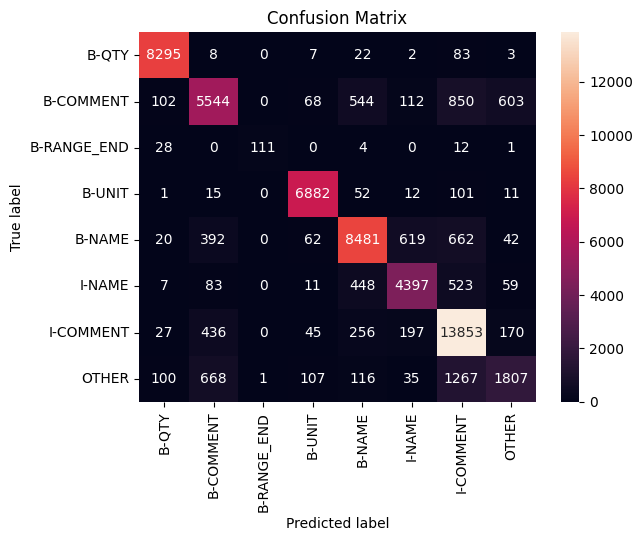

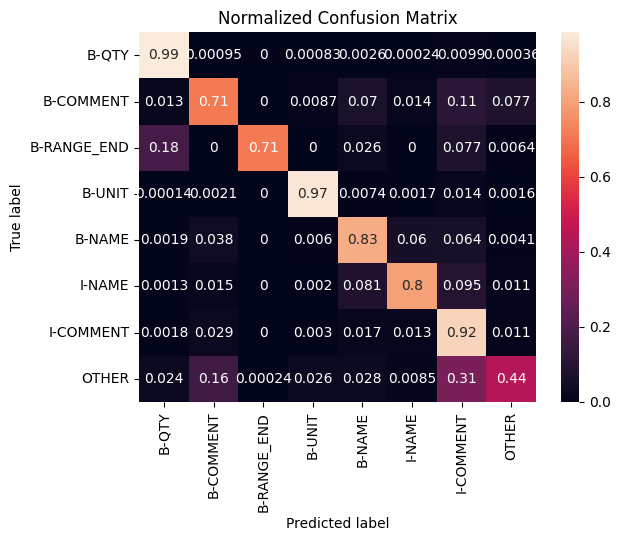

In [57]:
y_pred = []
y_true = []

for recipe, tags in test_data:
    y_pred += predict_tags(model,converter, recipe)
    y_true += tags
    
plot_confusion_matrix(y_true, y_pred, list(total_tags.keys()))
plot_confusion_matrix(y_true, y_pred, list(total_tags.keys()), normalize=True)


In [18]:
y_pred = []
y_true = []

for recipe, tags in training_data:
    y_pred += predict_tags(model,converter, recipe)
    y_true += tags
    
plot_confusion_matrix(y_true, y_pred, list(total_tags.keys()))
plot_confusion_matrix(y_true, y_pred, list(total_tags.keys()), normalize=True)

NameError: name 'total_tags' is not defined

In [1]:
total_correct, total_tags, wrong_recipes = tag_statistics(model, converter, training_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

print(wrong_recipes)

NameError: name 'tag_statistics' is not defined

In [19]:
# for i in wrong_recipes:

#     recipe, tags = test_data[i]
    
#     tags_pred = predict_tags(model, converter, recipe)

#     print('истинные тэги:')
#     show_markup(recipe, tags)

#     print('предсказанные тэги:')
#     show_markup(recipe, tags_pred)
#     print()

посмотреть какие рецепты с ошибками, разобрать разницу в результатах тестовой и тренировочной выборок, проблема в B I, исправить точность в матрице ошибок, убрать список ошибочных рецептов, подумать над проблемой other и i-comment